# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [1]:
#!pip install -qU langgraph==0.2.14 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.35 langchain-community

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [2]:
#!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Task 1: Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [2]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://arxiv.org/pdf/2404.19553").load()

Now we can chunk it down to size!

In [3]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

# tiktoken_len counts tokens (not characters) using the gpt-4o-mini tokenizer
def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

# We split the text into chunks of 300 tokens (not characters), with no overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

Now we've successfully split our single PDF into...

In [4]:
len(split_chunks)

15

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [5]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [6]:
from langchain_community.vectorstores import Qdrant

""" 
The line about memory means that the database will be stored in the RAM instead 
of on disk. This is faster, but means that the database will be lost when the 
program ends.

collection_name creates a named collection within Qdrant (similar to a 
table in a SQLdatabase).
"""
qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [7]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [8]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [9]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [10]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [11]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

'In the context of "long context" as mentioned in the document, "context" refers to the length of text or information that the language model can process or utilize at one time. Specifically, it pertains to the ability to handle larger amounts of text, such as books or long papers, allowing for tasks that require understanding and reasoning over extensive information. The document discusses extending the context length of the Llama-3 model from 8K tokens to 80K tokens, enabling it to manage and synthesize information from significantly longer texts.'

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [12]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [13]:
"""
Notice this returns a HumanMessage (not an AIMessage) so that the supervisor
agent distinguishes it from its own reasoning (which is represented as AIMessages)
"""
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [14]:
"""
Note that agent_scratchpad is dynamically managed behind the scenes by the
AgentExecutor. It's invisible to other agents (they only see the final messages).
This separation gives each agent its own "working memory" for complex
multi-step reasoning while keeping communcations between agents clean and 
focued on final outputs.
Also note that 'each agent is its own executor' means that each agent runs
its own reason, act, observe cycle autonomously. Each agent manages its own
tool usage without centralized control
"""

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [15]:
"""
function_def is a dictionary that defines the OpenAI function calling schema
for the routing decision. In other words, it enables the LLM to make routing
decisions in a predictable, parseable format rather than free text. When used
with llm.bind_functions(), it instructs the model to format its routing decision
as a specific function call.

function_call="route" forces the model to always use the "route" function 
(defined in function_def) rather than having the option to respond with free text
"""
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [17]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
  return rag_chain.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [18]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [19]:
llm = ChatOpenAI(model="gpt-4o-mini")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

##### Answer:

First of all, looking at the code below, we see that instances of this llm (gpt-4o-mini) is used for both the supervisor and the individual tool agents (tavily, RAG). 

Let's first discuss the supervisor: it needs to understand its purpose (be a router) and have contextual awareness (must track complex task progress across multiple agent interactions to make smart routing decisions). It needs sophisticated reasoning to determine when a complex (and open-ended!) task is actually completed. We need a powerful LLM to handle this level of reasoning. A less capable LLM might make poor routing decisions, lose track of conversation context, or fail to adapt after initial decisions don't work

Now let's discuss individual tool agents: each needs to understand its purpose (specialized role, operate within its narrow boundary), be its own executor (run
its own reason, act, observe cycle autonomously i.e. manage its own
tool usage without centralized control), and compile its findings into coherent, useful summaries for other agents to use. We need a powerful LLM to handle this level of reasoning. A less capable LLM might lose track of conversation context, act beyond its specialized role, manage its own tool usage poorly, or generate bad summaries of the work it did (which will confuse the other agents and lead to bad results)


### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [20]:
"""
We are creating a ready-to-use node for the graph that already knows which agent
to use (search_agent) and what name to tag message with (Search).
"""

search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [21]:
# This is similar to the cell above but for our RAG agent

research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'. You must only respond with information about the paper related to the request.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [22]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [23]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [24]:
"""
In the code below, note that 'lambda x: x["next"]' evaluates the 'next' field in
the current state. The dictionary that follows the lambda line maps possible values
of 'next' to the next node to route to.
"""

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [25]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

#### Display Graph

In [26]:
"""
This code allows asyncio-based code (like LangGraph operations) to run properly
within the Jupyter notebook environment
"""

import nest_asyncio
nest_asyncio.apply()

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

[INFO] Starting Chromium download.
100%|██████████| 141M/141M [00:06<00:00, 21.4Mb/s] 
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/kamerankolahi/Library/Application Support/pyppeteer/local-chromium/1181205


BrowserError: Browser closed unexpectedly:


The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [28]:
"""
Essentially, this makes the graph easier to use by automatically handling the
required state structure, allowing the user to just pass a simple string instead
of needing to create the proper state dictionary manually

We are doing this because later we need the ability to communicate between
different graphs
"""

def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [37]:
for s in research_chain.stream(
    "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use Search and PaperInformationRetriever!", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'PaperInformationRetriever'}}
---
{'PaperInformationRetriever': {'messages': [HumanMessage(content='The main takeaways from the paper "Extending Llama-3’s Context Ten-Fold Overnight" are:\n\n1. **Context Length Extension**: The authors successfully extended the context length of the Llama-3-8B-Instruct model from 8K to 80K tokens using QLoRA fine-tuning.\n\n2. **Efficient Training**: The entire training process was highly efficient, completed in just 8 hours on a single 8xA800 (80G) GPU machine.\n\n3. **Performance Improvements**: The resulting model demonstrated superior performance across various evaluation tasks, including NIHS, topic retrieval, and long-context language understanding, while still maintaining its original capabilities for short contexts.\n\n4. **Synthetic Training Samples**: The dramatic context extension was primarily achieved through the generation of 3.5K synthetic training samples using GPT-4, highlighting the untapped potential of large 

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

##### Answer:

   ![Activity 2 Annotated Graph](images/activity2_annotated_image.png)


##### Note:

Maybe my flow drawing in red is confusing (sorry!) so please let me explain the flow: we go from start to supervisor to PaperInformationRetriever to supervisor to FINISH to end (get our final response). Technically, the cell above doesn't print end on purpose (so not sure if I'm supposed to add that here), so just want to point that out

It's important to note that even though our query explicitly says to use Search and PaperInformationRetriever, we see that actually, the supervisor didn't follow directions! (it decided to FINISH before doing Search)




##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

##### Answer:

We can make sure our Agent uses specific tools (in this case here, both the Search and the PaperInformationRetriever) by adding to the research_chain. By that, I mean that we redefined research_chain to be 
research_chain = enter_chain | run_both_tool_agents | compiled_research_graph

where run_both_tool_agents is something like: 

def run_both_tool_agents(state):

    paper_result = research_node(state)
    
    search_result = search_node(state)
    
    combined_messages = state["messages"] + paper_result["messages"] + search_result["messages"]
    
    return {
        **state, 
        "messages": combined_messages,
        "next": "supervisor"
    }

I don't even think setting next to supervisor is necessary because the start node in compiled_research_graph is the supervisor node, but this is just to be safe (and helps for debugging).

This is just one way of doing this, there are others. But this is one way by concretely setting a flow through the tools by adding to our research_chain chain

# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [31]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

"""
Because our Document Writing Team is actually going to be writing files, we need
to create a working directory for them to write to. We do this by making a 
content directory (inside the 06_Multi_Agent_with_LangGraph directory) then a data 
subdirectory inside it and then a subdirectory inside that whos name is the first 
8 characters of a UUID, which is created each time this cell is run
"""

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

##### Answer:

create_outline: it receives as input a file path and a list of points (as a list of strings). It opens the file (whose file path was an input) and writes a numbered list (starting at 1) of points into the file (where the points are the points provided as input) with a newline between points. It returns a string saying it saved the outline to the path. In other words, this tool creates an outline 

read_document: it receives as input a file path, an optional start line (otherwise it starts at the beginning of the file), an optional end line, and it reads these lines. What it's really doing is returning a string with the lines it read (with a newline inbetween these lines). The purpose of this is to extract this text to provide context to our agents

write_document: it receives as input a file path and text content (as type string). It then opens the file and writes and saves the provided content string directly into the file (no formatting changes). When it's done, it closes the file (thanks to the with statement) and returns a confirmation message saying the document was saved to the file path. Essentially, it allows agents to write documents

edit_document: it receives as input a file path and a dictionary that maps line numbers (as in line in the file, starting at 1 not 0) to text to insert at those positions. Essentially, edit_document inserts (writes) the provided text (value in the dictionary) in the file on line {whatever its key is in the dictionary}, provided that the key in the dictionary is a valid line number for the file. It's important to note that edit_document does NOT delete or overwrite existing content on the line, it just inserts new lines at the specified positions, pushing the existing content down. It allows agents to make insertion edits into a document without having to rewrite the entire document

Extra: A more detailed description of edit_document is: it receives as input a file path and a dictionary that maps line numbers (as in line in the file, starting at 1 not 0) to text to insert at those positions. It then opens the file, sorts the dictionary by line number, validates that the line numbers are within range (otherwise returns an error message), then inserts (writes) the provided text (value in the dictionary) in the file on line {whatever its key is in the dictionary} followed by a newline. When it's done with all these, it returns a confirmation message saying that the document was edited and saved to the file path. 

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [32]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [33]:
"""
This function scans the working directory and updates the state (specifically 
the current_files field) with a bulleted list of available files in the working 
directory (or says no files written if the directory is empty)
"""

def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [43]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [45]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

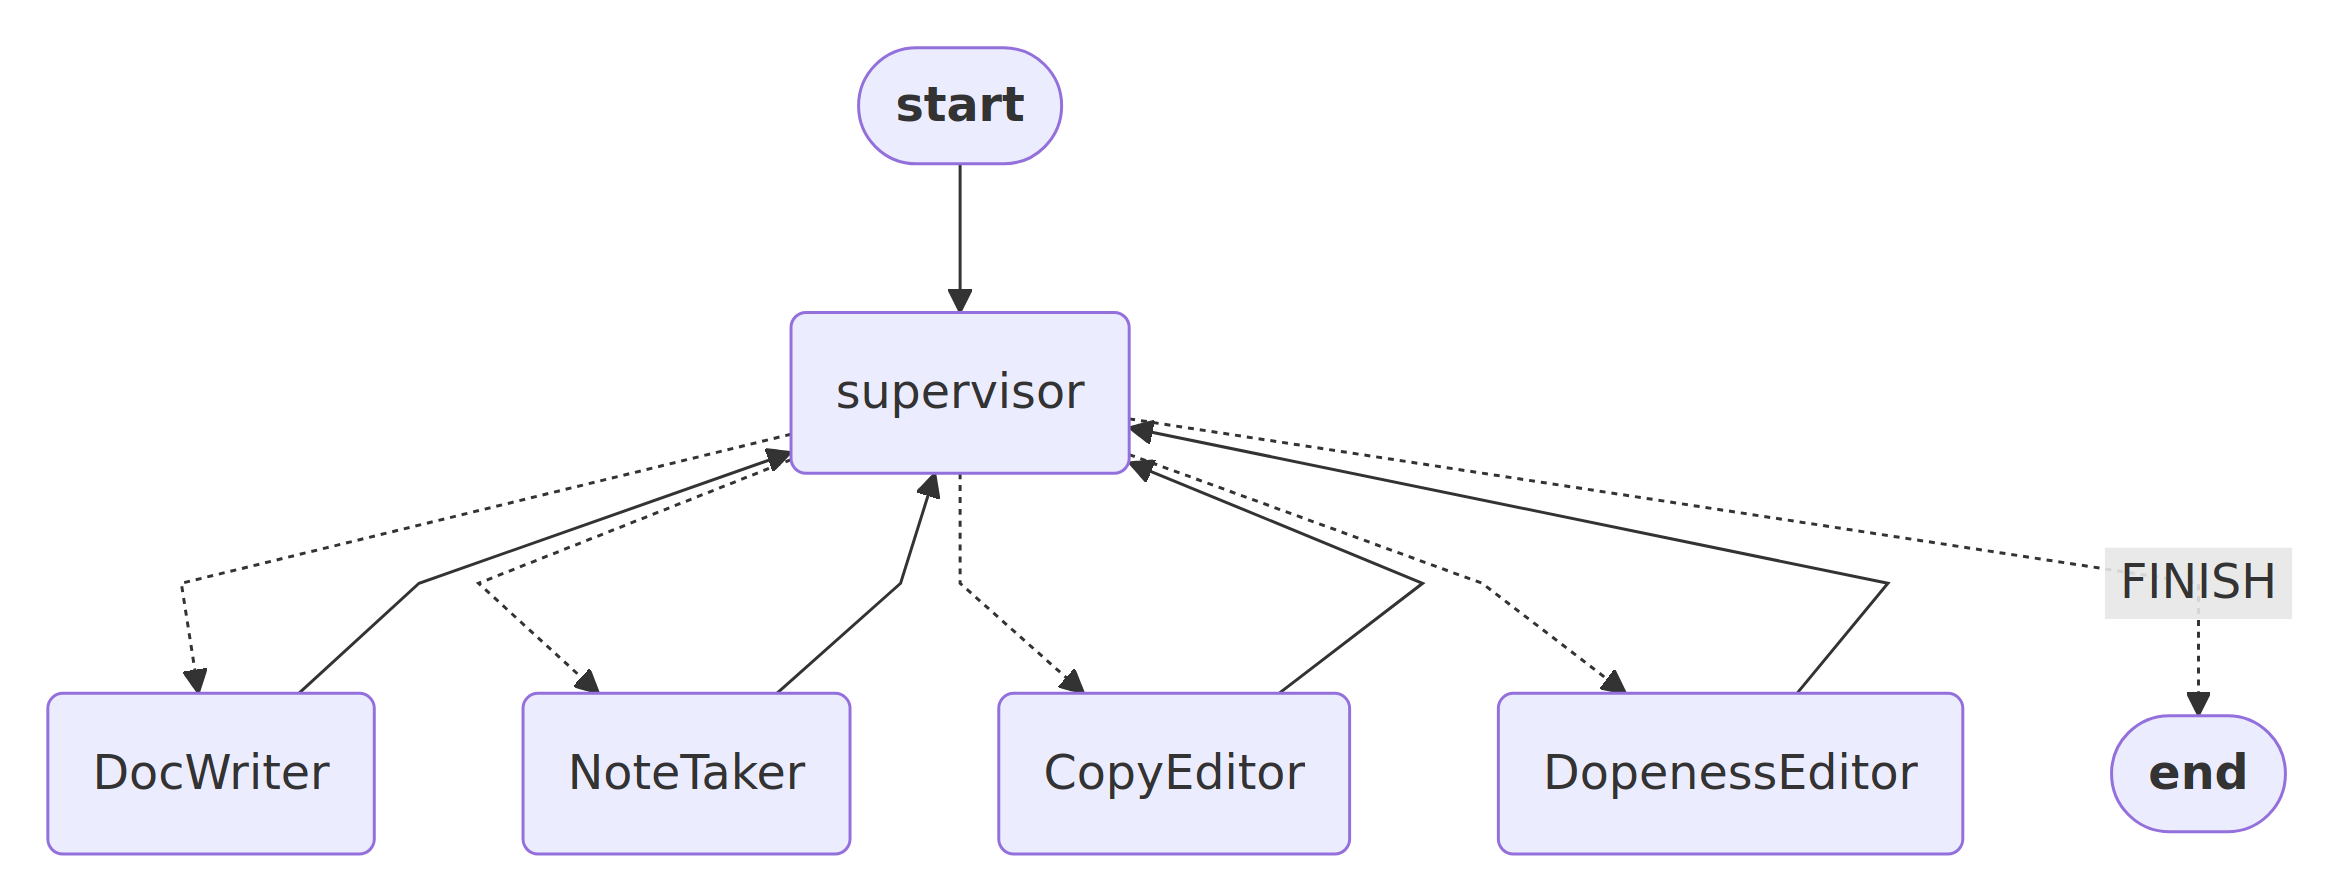

In [46]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [47]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [48]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully written to disk. You can find it in the file named "linear_regression_linkedin_post_outline.txt".', name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully created and saved to disk. You can find it in the file named "linear_regression_linkedin_post_outline.txt".', name='NoteTaker')]}}
---
{'supervisor': {'next': 'CopyEditor'}}
---
{'CopyEditor': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully edited and saved to the file named "linear_regression_linkedin_post_outline.txt".', name='CopyEditor')]}}
---
{'supervisor': {'next': 'DopenessEditor'}}
---
{'DopenessEditor': {'messages': [HumanMessage(content='The outline for the

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [50]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [56]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [57]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [58]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [60]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='🚀 Exciting News in AI Research! 🚀\n\nI am thrilled to share that a groundbreaking paper titled "Extending Llama-3’s Context Ten-Fold Overnight" has just been published! The research team has achieved an incredible feat by extending the context length of the Llama-3-8B-Instruct model from 8,000 tokens to a staggering 80,000 tokens. This advancement opens up new possibilities for processing and understanding longer pieces of text, providing significant improvements in various applications.\n\nUsing a technique called Quantized Low-Rank Adaptation (QLoRA), the team fine-tuned the model efficiently, completing the entire training process in just 8 hours on a powerful GPU. Remarkably, the model not only excels in long-context tasks but also retains its original capabilities for shorter contexts. 🎉\n\nThe implications of this research are profound, enhancing performance across diverse evaluati

## SAMPLE POST!

🚀 Exciting News in AI Research! 🚀

We're thrilled to share a groundbreaking achievement in the field of large language models (LLMs)! A recent study titled "Extending Llama-3’s Context Ten-Fold Overnight" has successfully expanded the context length of Llama-3 from 8K to a staggering 80K tokens using QLoRA fine-tuning. This enhancement was accomplished in just eight hours on a single 8xA800 (80G) GPU machine, demonstrating both efficiency and effectiveness in model training.

🔍 This remarkable advancement not only improves Llama-3’s performance across various benchmarks such as NIHS, topic retrieval, and long-context language understanding, but also preserves the model's ability to generalize beyond its training contexts, handling up to 128K tokens. This capability makes it a formidable tool in processing extensive textual information, pushing the boundaries of what AI can achieve.

📊 Evaluated on LongBench and InfiniteBench, the model consistently outperformed baselines, setting a new standard in the field. Although it faced challenges in code completion tasks, the overall results are overwhelmingly positive.

🌐 The full resources, including the model, training data, and code, are now publicly available, providing an invaluable asset for further research in training long-context LLMs.

🔗 For more details, check out the full paper [here](https://www.emergentmind.com/papers/2404.19553).

Let's continue pushing the limits of what AI can do! #AILLMs #MachineLearning #AIResearch #LanguageModels #Innovation
